# Прогнозирование временных рядов при помощи машинного обучения. Домашнее задание

Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Предобработка временного ряда

Импорт библиотек

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [111]:
# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

Оставим только целевой ряд (`quantity`)

In [112]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

ts.head()

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390


Посмотрим как ведет себя временной ряд

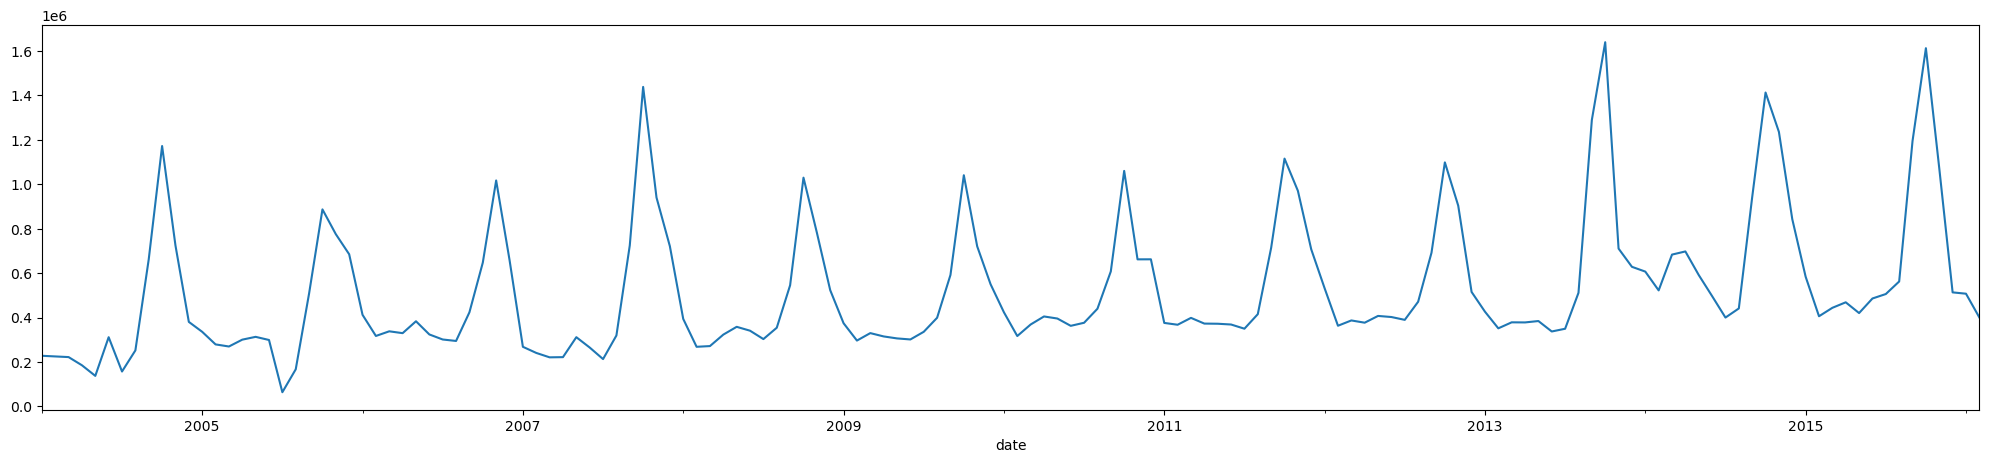

In [113]:
ts.quantity.plot(figsize=(25,5));

## Машинное обучение для прогнозирования временных рядов

## Задание

Извлеките первые 7 лаговых признаков из ряда (лаг на 1, 2 ... 7 месяцев).

Чему равно первое (самое старое) известное значение лага 4 периода назад (lag_4)? Ответ округлите до целого числа.

In [114]:
for i in range(1,8):
    ts[f'lag_{i}'] = ts['quantity'].shift(i)
    
ts.head()

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2004-01,227832,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-02,225133,227832.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-03,221952,225133.0,227832.0,NaN,NaN,NaN,NaN,NaN
2004-04,185150,221952.0,225133.0,227832.0,NaN,NaN,NaN,NaN
2004-05,137390,185150.0,221952.0,225133.0,227832.0,NaN,NaN,NaN


In [115]:
ts['lag_4'].iloc[4]

227832.0

Выкиньте строчки с пропущенными значениями.

In [116]:
ts.dropna(inplace=True)
ts.head()

,quantity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2004-08,251984,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0,227832.0
2004-09,662382,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0,225133.0
2004-10,1171846,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0,221952.0
2004-11,724140,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0,185150.0
2004-12,380379,724140.0,1171846.0,662382.0,251984.0,157022.0,311445.0,137390.0


### Разбиение на train и test для временных рядов

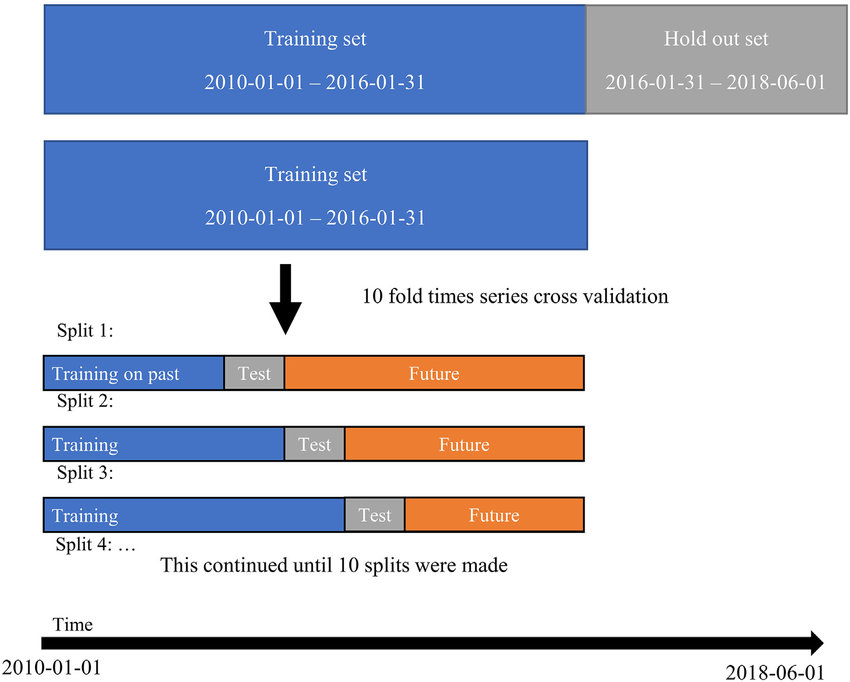

## Задание

Разбейте данные (quantity) на train и test.

train - первые 85% данных

test - следующие 15% данных

Сколько измерений попало в тестовую часть?

In [117]:
split_index = int(0.85*len(ts))

Train = ts[:split_index]
Test = ts[split_index:]

In [118]:
Test.shape[0]

21

## Задание

Разбейте тренировочные и тестовые данные на матрицы объект-признак `X_train`, `X_test` и векторы с целевой переменной `y_train`, `y_test`.

Чему равно среднее значение `y_test`? Ответ округлите до целого числа

In [119]:
from sklearn.model_selection import train_test_split

X_train = Train.drop('quantity', axis=1)
X_test = Test.drop('quantity', axis=1)

y_train = Train['quantity']
y_test = Test['quantity']

y_test.mean()

711637.0

## Прогнозирование временных рядов

Обратите внимание, что в функции мы сами по индексу разбили датасет на обучающую и валидационную выборку для обучения моделей. Мы не можем воспользовать train_test_split, так как нам необходимо сохранять хронологию в деление выборки на части, т.е. случайное сэмплирование наблюдений нам не подойдет, в частности, т.к. мы хотим выучить тренд в данных.

## Задание

Обучите линейную регрессию на тренировочных данных и посчитайте $R^2$ на тесте.

Ответ округлите до сотых.

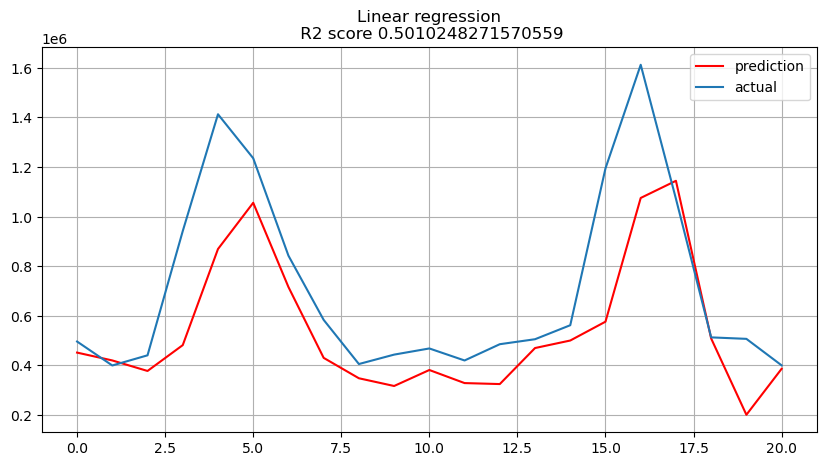

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R2 score {r2_score(y_test, preds)}");

## Агрегированные признаки

Используем функцию, которая возвращает словарь, где ключами являются уникальные категории признака `cat_feature`, а значениями - средние по `real_feature`.

In [121]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

## Задание

Создайте колонку `month`, содержащую месяц (из даты).

Вычислите среднее значение целевой переменной по месяцам (по всем обучающим данным до разбиения на train и test).

В какой месяц года среднее количество проданного товара максимально? В ответе укажите номер месяца.

In [136]:
ts['month'] = ts.index.month
ts.groupby('month')['quantity'].mean().sort_values(ascending=False)

month
10    1.179205e+06
11    8.760303e+05
9     7.411839e+05
12    6.155788e+05
1     4.205678e+05
8     3.854567e+05
5     3.649648e+05
4     3.644232e+05
3     3.592498e+05
6     3.578258e+05
2     3.348675e+05
7     3.120223e+05
Name: quantity, dtype: float64

Далее будем использовать функцию preprocess_data.

В функции мы:

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [137]:
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [138]:
index_cut = int(0.815*len(ts))

In [139]:
def preprocess_data(data, lag_start=1, lag_end=8, index_cut=index_cut):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['quantity'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.iloc[:index_cut], "month", "quantity").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:index_cut].drop(["quantity"], axis=1)
    y_train = data.iloc[:index_cut]["quantity"]
    X_test = data.iloc[index_cut:].drop(["quantity"], axis=1)
    y_test = data.iloc[index_cut:]["quantity"]

    return X_train, X_test, y_train, y_test

In [140]:
X_train, X_test, y_train, y_test = preprocess_data(ts)

X_train.shape, X_test.shape

((118, 8), (21, 8))

## Задание

Обучите линейную регрессию на подготовленных тренировочных данных и выведите $R^2$ на тесте.

Ответ округлите до сотых.

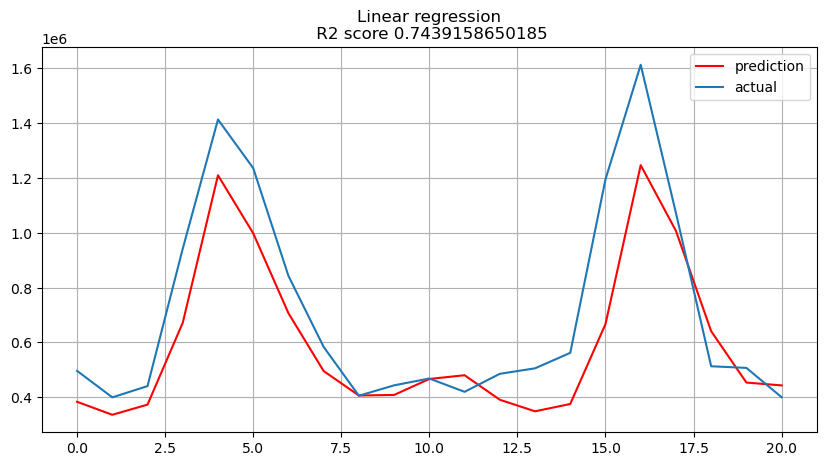

In [141]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R2 score {r2_score(y_test, preds)}");

## Задание

Заново разбейте данные на train и test, используя `preprocess_data` с лагами от 1 до 12 не включительно.

Обучите линейную регрессию. Чему теперь равен $R^2$? Ответ округлите до сотых.

In [143]:
X_train, X_test, y_train, y_test = preprocess_data(ts, lag_start=1, lag_end=12)

X_train.shape, X_test.shape

((118, 12), (17, 12))

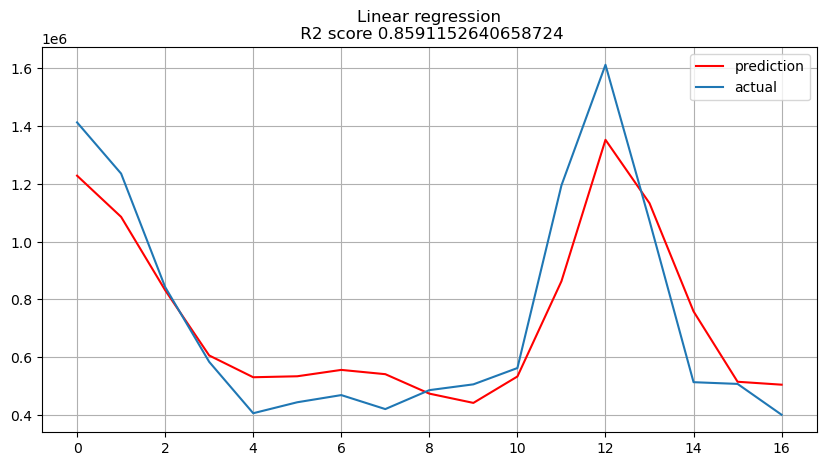

In [144]:
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R2 score {r2_score(y_test, preds)}");

## Задание

Обучите CatBoostRegressor с гиперпараметрами по умолчанию на тех же данных, что и линейную регрессию из предыдущего задания. Чему теперь равен $R^2$? Ответ округлите до десятых.

In [129]:
# !pip install catboost -q

Learning rate set to 0.02921
0:	learn: 265587.3165548	total: 61.6ms	remaining: 1m 1s
1:	learn: 261071.8931381	total: 63ms	remaining: 31.4s
2:	learn: 257368.8273561	total: 64.1ms	remaining: 21.3s
3:	learn: 253479.6090882	total: 64.9ms	remaining: 16.2s
4:	learn: 249768.1752293	total: 65.6ms	remaining: 13.1s
5:	learn: 246291.4309278	total: 66.3ms	remaining: 11s
6:	learn: 243507.5633421	total: 67ms	remaining: 9.51s
7:	learn: 240550.1037802	total: 67.8ms	remaining: 8.4s
8:	learn: 237176.9677208	total: 68.5ms	remaining: 7.54s
9:	learn: 233132.0312718	total: 69.4ms	remaining: 6.87s
10:	learn: 230177.1660152	total: 70.3ms	remaining: 6.32s
11:	learn: 226849.9185607	total: 71.1ms	remaining: 5.86s
12:	learn: 223704.5036253	total: 71.9ms	remaining: 5.46s
13:	learn: 221180.3745426	total: 72.8ms	remaining: 5.13s
14:	learn: 218267.8346022	total: 73.5ms	remaining: 4.83s
15:	learn: 214548.8285753	total: 74.2ms	remaining: 4.56s
16:	learn: 211767.5314004	total: 74.9ms	remaining: 4.33s
17:	learn: 208769.8

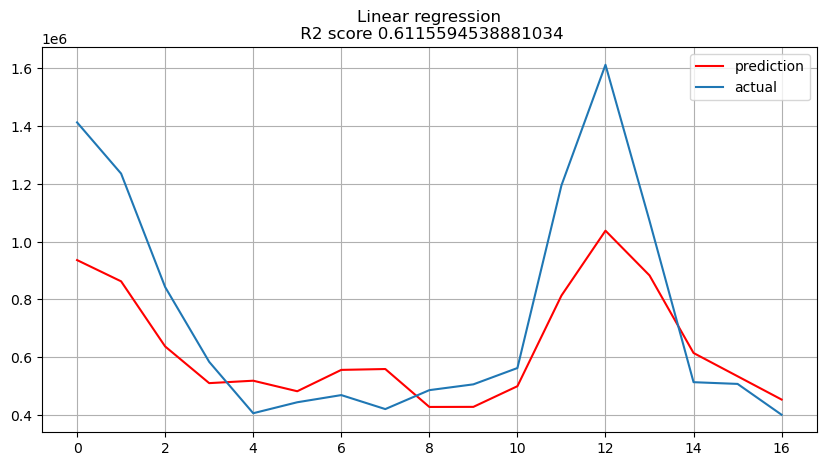

In [145]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor()
cat.fit(X_train, y_train)
preds = cat.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n R2 score {r2_score(y_test, preds)}");